In [28]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import fits
from scipy.signal import fftconvolve
from scipy.ndimage import zoom
from scipy.special import j1 as J1
from scipy.ndimage import map_coordinates

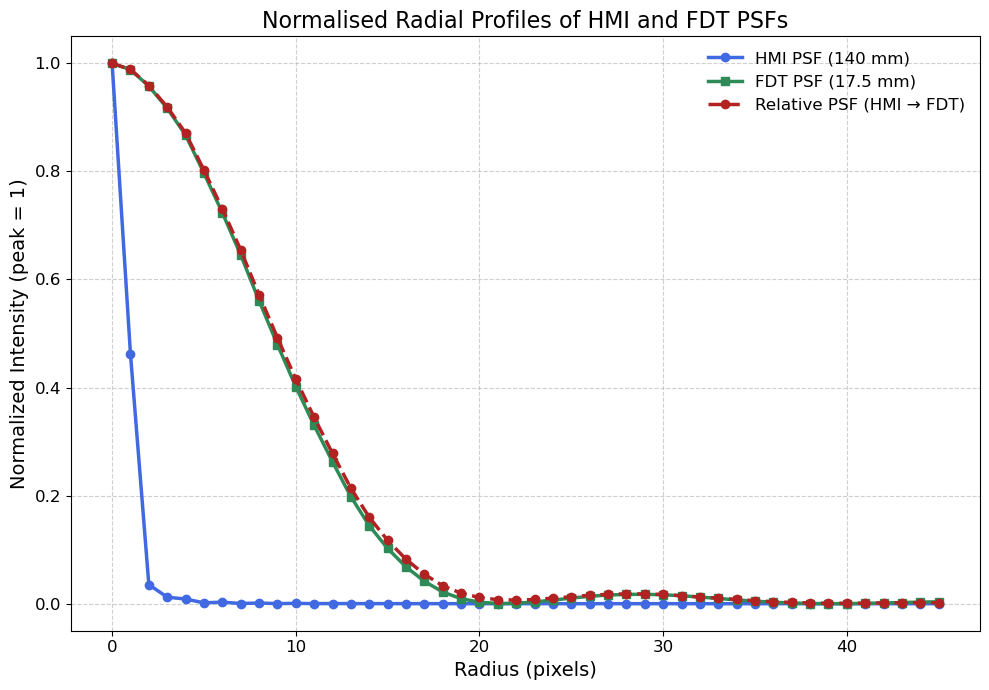

In [29]:
# Re-import necessary libraries after kernel reset
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from scipy.special import j1 as J1

def airy_disk_psf(shape, airy_radius_pixels):
    """Generate 2D Airy disk PSF centered in array of given shape."""
    y, x = np.indices(shape)
    cy, cx = shape[0] // 2, shape[1] // 2
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r[cy, cx] = 1e-10  # prevent divide by zero
    k = np.pi * r / airy_radius_pixels
    psf = (2 * J1(k) / k)**2
    psf /= psf.sum()
    return psf

def compute_airy_radius_pixels(wavelength_m, aperture_m, pixel_scale_arcsec):
    """Compute Airy disk radius in image pixels based on aperture and pixel scale."""
    theta_rad = 1.22 * wavelength_m / aperture_m
    pixel_scale_rad = pixel_scale_arcsec / 206265.0
    return theta_rad / pixel_scale_rad

# Settings
wavelength = 617.3e-9  # meters
pixel_scale = 0.5  # arcsec/pixel (HMI resolution)

# Apertures
aperture_hmi = 0.14  # meters
aperture_fdt = 0.0175  # meters

# Compute Airy radii
radius_hmi = compute_airy_radius_pixels(wavelength, aperture_hmi, pixel_scale)
radius_fdt = compute_airy_radius_pixels(wavelength, aperture_fdt, pixel_scale)

# PSF grid size (ensure big enough for both PSFs)
psf_shape = (64, 64)

# Generate PSFs
psf_hmi = airy_disk_psf(psf_shape, radius_hmi)
psf_fdt = airy_disk_psf(psf_shape, radius_fdt)

# Relative PSF (additional blur required to simulate PMI from HMI)
psf_rel = fftconvolve(psf_fdt, psf_hmi[::-1, ::-1], mode='same')

# Plot radial profiles
def radial_profile(psf):
    cy, cx = np.array(psf.shape) // 2
    y, x = np.indices(psf.shape)
    r = np.sqrt((x - cx)**2 + (y - cy)**2)
    r = r.astype(int)
    tbin = np.bincount(r.ravel(), psf.ravel())
    nr = np.bincount(r.ravel())
    return tbin / np.maximum(nr, 1)

r_profile_hmi = radial_profile(psf_hmi)
r_profile_fdt = radial_profile(psf_fdt)
r_profile_rel = radial_profile(psf_rel)

# Normalize profiles to the same peak height
r_profile_hmi /= r_profile_hmi.max()
r_profile_fdt /= r_profile_fdt.max()
r_profile_rel /= r_profile_rel.max()

# Define the maximum radius to display
r_max = 64

# Plot
plt.figure(figsize=(10, 7))
plt.plot(r_profile_hmi[:r_max], label='HMI PSF (140 mm)', lw=2.5, color='royalblue', marker='o')
plt.plot(r_profile_fdt[:r_max], label='FDT PSF (17.5 mm)', lw=2.5, color='seagreen', marker='s')
plt.plot(r_profile_rel[:r_max], label='Relative PSF (HMI → FDT)', lw=2.5, linestyle='--', marker='o', color='firebrick')

# Axes labels and title
plt.xlabel("Radius (pixels)", fontsize=14)
plt.ylabel("Normalized Intensity (peak = 1)", fontsize=14)
plt.title("Normalised Radial Profiles of HMI and FDT PSFs", fontsize=16)

# Legend formatting
plt.legend(frameon=False, fontsize=12, loc='upper right')

# Ticks and grid
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()


In [30]:
# ------------------------------
# Parameters (put outside)
# ------------------------------
# Wavelength
wavelength_m = 617.3e-9  # 617.3 nm

# Apertures
aperture_hmi = 0.14      # 14 cm HMI
aperture_fdt = 0.0175    # 17.5 mm FDT

# Pixel scales
pix_hmi = 0.5            # arcsec/px (HMI)
pix_fdt = 3.75           # arcsec/px (FDT at 0.5 AU)

# Distances
hmi_distance_au = 1.0
fdt_distance_au = 0.5

# Solar radius for scaling
solar_radius_arcsec_hmi = 960.0  # arcsec at 1 AU
solar_radius_arcsec_fdt = solar_radius_arcsec_hmi * (hmi_distance_au / fdt_distance_au)

# PSF size (enough to cover Airy wings)
psf_size = 64

# Build PSFs on the HMI pixel grid
radius_hmi_px = compute_airy_radius_pixels(wavelength_m, aperture_hmi, pix_hmi)
radius_fdt_on_hmi_px = compute_airy_radius_pixels(wavelength_m, aperture_fdt, pix_hmi)
psf_hmi = airy_disk_psf((psf_size, psf_size), radius_hmi_px)
psf_fdt_on_hmi = airy_disk_psf((psf_size, psf_size), radius_fdt_on_hmi_px)

# Relative PSF: FDT ⊗ HMI^(-1) (approximate)
psf_rel_fdt = fftconvolve(psf_fdt_on_hmi, psf_hmi[::-1, ::-1], mode='same')


# ------------------------------
# Simulation function
# ------------------------------
def simulate_fdt_from_hmi(hmi_image, psf_rel, pix_hmi=0.5, pix_fdt=3.75,
                          hmi_distance_au=1.0, fdt_distance_au=0.5):
    """
    Simulate Solar Orbiter FDT from HMI image.

    Steps:
      1. Blur HMI with relative PSF.
      2. Rescale solar disk from 1 AU → 0.5 AU.
      3. Resample to FDT pixel scale (3.75"/px).
    """
    # 1. Blur to FDT optics
    blurred = fftconvolve(hmi_image, psf_rel, mode='same')

    # 2. Scale solar disk size (HMI → FDT distance)
    scale_factor = (hmi_distance_au / fdt_distance_au) * (pix_hmi / pix_fdt)

    ny, nx = blurred.shape
    cy, cx = ny // 2, nx // 2
    y, x = np.indices((2048, 2048))
    x = (x - 1024) / scale_factor + cx
    y = (y - 1024) / scale_factor + cy

    # 3. Interpolate onto new grid
    fdt_image = map_coordinates(blurred, [y, x], order=1, mode='constant', cval=0.0)

    return fdt_image

['t_rec', 't_obs', 'quality', 'crpix1', 'crpix2', 'crval1', 'crval2', 'cdelt1', 'cdelt2', 'crota2', 'crln_obs', 'crlt_obs', 'rsun_obs', 'isbad', 'path']
First 10 paths:
/pfs/scratch/SUMS/SUM0565/D516597790/S00008

/pfs/scratch/SUMS/SUM0565/D516597790/S00009

/pfs/scratch/SUMS/SUM0565/D516597790/S00010

/pfs/scratch/SUMS/SUM0565/D516597790/S00011

/pfs/scratch/SUMS/SUM0565/D516597790/S00012

/pfs/scratch/SUMS/SUM0565/D516597790/S00013

/pfs/scratch/SUMS/SUM0565/D516597790/S00014

/pfs/scratch/SUMS/SUM0565/D516597790/S00015

/pfs/scratch/SUMS/SUM0565/D516597790/S00016

/pfs/scratch/SUMS/SUM0565/D516597790/S00017

First 10 t_rec:
2014.01.01_00:00:00_TAI
2014.01.01_00:00:45_TAI
2014.01.01_00:01:30_TAI
2014.01.01_00:02:15_TAI
2014.01.01_00:03:00_TAI
2014.01.01_00:03:45_TAI
2014.01.01_00:04:30_TAI
2014.01.01_00:05:15_TAI
2014.01.01_00:06:00_TAI
2014.01.01_00:06:45_TAI
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan n

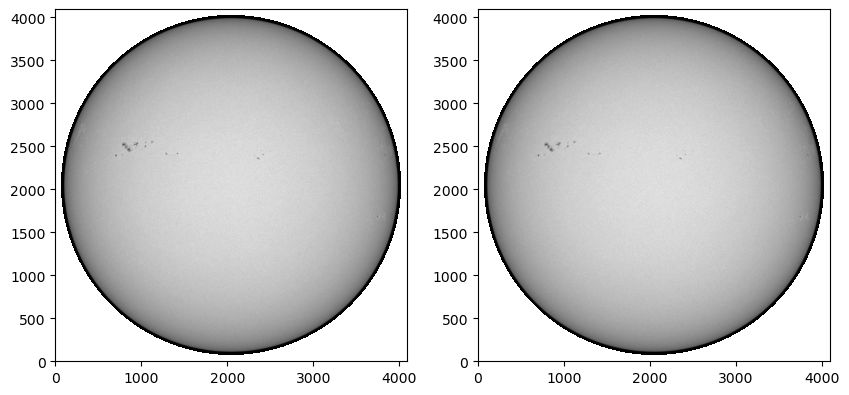

In [31]:
f = Table.read('/scratch/seismo/joshin/pipeline-test/IterativeLCT/hmi.ic_45s/keys_new_swan/keys-2014.fits')
# print keys
print(f.keys())
# Get paths and t_rec
paths = f['path']
t_rec = f['t_rec']
crpix1 = f['crpix1']
# Get the first 10 path and t_rec
print('First 10 paths:')
for i in range(10):
    print(paths[i])
print('First 10 t_rec:')
for i in range(10):
    print(t_rec[i])

# Make array from the continuum.fits files
njump = 1800//45
final_paths = [paths[i*njump][:-1] + '/continuum.fits' for i in range(1,3)]
imgs = [fits.open(final_paths[i])[1].data for i in range(len(final_paths))]
crpixs = [crpix1[i] for i in range(len(final_paths))]
print(imgs[0])

figs, ax = plt.subplots(1, 2, figsize=(10, 10))
for i in range(2):
    ax[i].imshow(imgs[i], cmap='gray', origin='lower')

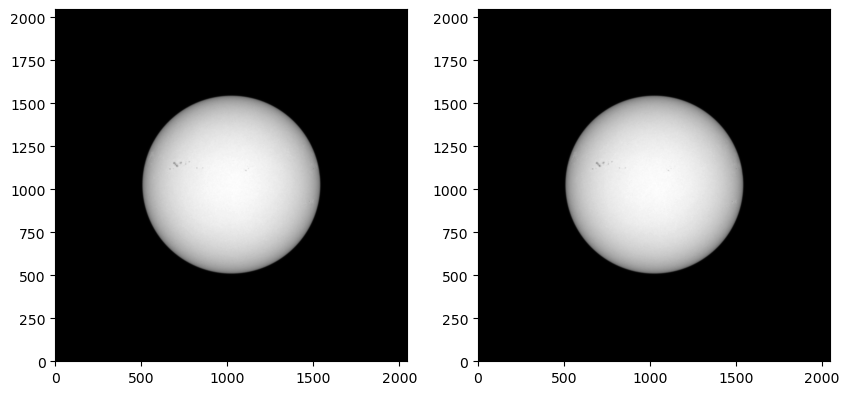

In [32]:
# psf, blurred, img1_2k = downsample_hmi_to_pmi(np.nan_to_num(imgs[0]))
# _, _, img2_2k = downsample_hmi_to_pmi(np.nan_to_num(imgs[1]))

img1_2k = simulate_fdt_from_hmi(np.nan_to_num(imgs[0]), psf_rel_fdt)
img2_2k = simulate_fdt_from_hmi(np.nan_to_num(imgs[1]), psf_rel_fdt)


fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(img1_2k, cmap='gray', origin='lower')
ax[1].imshow(img2_2k, cmap='gray', origin='lower')
# im = ax[2].imshow(psf, cmap='gray', vmin=0, vmax=1e-15)
# plt.colorbar(im, ax=ax[2])

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import astropy.units as u
from scipy.ndimage import map_coordinates
from astropy.time import Time
from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

def make_wcs_from_keys_table(keys_table, fdt_shape=(2048, 2048), pix_fdt=3.75):
    """
    Build HMI and FDT WCS from keys.fits table (ensures proper units).

    Returns:
        hmi_wcs, fdt_wcs: astropy.wcs.WCS objects
    """
    keys = keys_table[0]  # single row

    # Build HMI header
    hmi_header = fits.Header()
    for col in keys.colnames:
        try:
            hmi_header[col] = keys[col]
        except Exception:
            pass
    # Ensure units
    hmi_header['CUNIT1'] = 'arcsec'
    hmi_header['CUNIT2'] = 'arcsec'
    hmi_wcs = WCS(hmi_header)

    # Build FDT header
    fdt_header = hmi_header.copy()
    ny, nx = fdt_shape
    fdt_header['NAXIS1'] = nx
    fdt_header['NAXIS2'] = ny
    fdt_header['CDELT1'] = pix_fdt
    fdt_header['CDELT2'] = pix_fdt
    fdt_header['CRPIX1'] = nx / 2.0
    fdt_header['CRPIX2'] = ny / 2.0
    fdt_header['CUNIT1'] = 'arcsec'
    fdt_header['CUNIT2'] = 'arcsec'
    fdt_wcs = WCS(fdt_header)

    return hmi_wcs, fdt_wcs


import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from sunpy.coordinates import frames
import astropy.units as u
from scipy.ndimage import map_coordinates
from astropy.time import Time

def plot_hmi_fdt_patch_disk_fixed(hmi_image, fdt_image, hmi_wcs, fdt_wcs, keys_table,
                                  lat_range=(-90, 90), lon_range=(-90, 90),
                                  hmi_pixscale_deg=0.03, cmap='gray', fdt_distance_au=0.5):
    """
    Plot the same heliographic patch from HMI and synthetic FDT images,
    sampling HMI at a fixed angular resolution (deg/px), and FDT at its
    native pixel scale.

    Parameters
    ----------
    hmi_image : 2D ndarray
        HMI image array.
    fdt_image : 2D ndarray
        Synthetic FDT image array.
    hmi_wcs : astropy.wcs.WCS
        WCS for HMI image.
    fdt_wcs : astropy.wcs.WCS
        WCS for synthetic FDT image.
    keys_table : astropy.table.Table
        Table containing header keys, must include 'RSUN_OBS' in arcsec.
    lat_range : tuple
        Latitude range in degrees.
    lon_range : tuple
        Longitude range in degrees.
    hmi_pixscale_deg : float
        Desired angular resolution for HMI sampling in degrees per pixel.
    cmap : str
        Colormap for plotting.
    fdt_distance_au : float
        Observer distance for FDT in AU.
    """
    # Angular size of patch
    lat_extent = lat_range[1] - lat_range[0]
    lon_extent = lon_range[1] - lon_range[0]

    # Patch size in HMI pixels (from fixed 0.03 deg/px)
    patch_size_hmi = int(np.round(lat_extent / hmi_pixscale_deg))
    # Use same for both axes
    patch_size_hmi = max(1, patch_size_hmi)

    # Pixel scales from WCS
    scale_hmi = abs(hmi_wcs.wcs.cdelt[0]) * u.arcsec
    scale_fdt = abs(fdt_wcs.wcs.cdelt[0]) * u.arcsec

    print(f"HMI pixel scale: {scale_hmi.to(u.deg)}")
    print(f"FDT pixel scale: {scale_fdt.to(u.deg)}")

    # Equivalent FDT patch size (scale ratio)
    patch_size_fdt = int(np.round(patch_size_hmi * (scale_hmi / scale_fdt).decompose().value))
    patch_size_fdt = max(1, patch_size_fdt)

    # --- Build lat-lon grids ---
    lat_grid_hmi = np.linspace(lat_range[0], lat_range[1], patch_size_hmi)
    lon_grid_hmi = np.linspace(lon_range[0], lon_range[1], patch_size_hmi)
    lon_hmi, lat_hmi = np.meshgrid(lon_grid_hmi, lat_grid_hmi)

    lat_grid_fdt = np.linspace(lat_range[0], lat_range[1], patch_size_fdt)
    lon_grid_fdt = np.linspace(lon_range[0], lon_range[1], patch_size_fdt)
    lon_fdt, lat_fdt = np.meshgrid(lon_grid_fdt, lat_grid_fdt)

    obstime = Time('2020-01-01T00:00:00')

    # SkyCoords
    hg_hmi = SkyCoord(lon_hmi*u.deg, lat_hmi*u.deg,
                      frame=frames.HeliographicStonyhurst, obstime=obstime)
    hg_fdt = SkyCoord(lon_fdt*u.deg, lat_fdt*u.deg,
                      frame=frames.HeliographicStonyhurst, obstime=obstime)

    # Observers
    hmi_obs = SkyCoord(0*u.deg, 0*u.deg, 1*u.au,
                       frame=frames.HeliographicStonyhurst, obstime=obstime)
    fdt_obs = SkyCoord(0*u.deg, 0*u.deg, fdt_distance_au*u.au,
                       frame=frames.HeliographicStonyhurst, obstime=obstime)

    # Frames
    hmi_hpc = frames.Helioprojective(observer=hmi_obs)
    fdt_hpc = frames.Helioprojective(observer=fdt_obs)

    # Transform
    hmi_xy = hg_hmi.transform_to(hmi_hpc)
    fdt_xy = hg_fdt.transform_to(fdt_hpc)

    # RSUN
    RSUN_HMI = keys_table['rsun_obs'][0] * u.arcsec
    RSUN_FDT = RSUN_HMI * (1 / fdt_distance_au)

    # Masks
    hmi_mask = (hmi_xy.Tx**2 + hmi_xy.Ty**2) <= RSUN_HMI**2
    fdt_mask = (fdt_xy.Tx**2 + fdt_xy.Ty**2) <= RSUN_FDT**2

    # Pixel coords
    hmi_px, hmi_py = hmi_wcs.world_to_pixel(hmi_xy.Tx[hmi_mask], hmi_xy.Ty[hmi_mask])
    fdt_px, fdt_py = fdt_wcs.world_to_pixel(fdt_xy.Tx[fdt_mask], fdt_xy.Ty[fdt_mask])

    # Empty patches
    hmi_patch = np.full(hmi_xy.Tx.shape, np.nan)
    fdt_patch = np.full(fdt_xy.Tx.shape, np.nan)

    # Interpolate
    hmi_patch[hmi_mask] = map_coordinates(hmi_image, [hmi_py, hmi_px], order=1, mode='nearest')
    fdt_patch[fdt_mask] = map_coordinates(fdt_image, [fdt_py, fdt_px], order=1, mode='nearest')

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

    im1 = axes[0].imshow(hmi_patch, origin='lower', cmap=cmap,
                         extent=[lon_range[0], lon_range[1],
                                 lat_range[0], lat_range[1]])
    axes[0].set_title(f"HMI patch ({patch_size_hmi}px, {hmi_pixscale_deg}°/px)")
    axes[0].set_xlabel("Longitude [deg]")
    axes[0].set_ylabel("Latitude [deg]")

    im2 = axes[1].imshow(fdt_patch, origin='lower', cmap=cmap,
                         extent=[lon_range[0], lon_range[1],
                                 lat_range[0], lat_range[1]])
    axes[1].set_title(f"FDT patch ({patch_size_fdt}px, native)")
    axes[1].set_xlabel("Longitude [deg]")
    axes[1].set_ylabel("Latitude [deg]")

    fig.colorbar(im2, ax=axes, orientation="horizontal", fraction=0.05, pad=0.1)
    plt.show()
    print(f"Patch sizes: HMI {patch_size_hmi}px, FDT {patch_size_fdt}px")


HMI pixel scale: 0.00014007972222222222 deg
FDT pixel scale: 0.0010416666666666667 deg


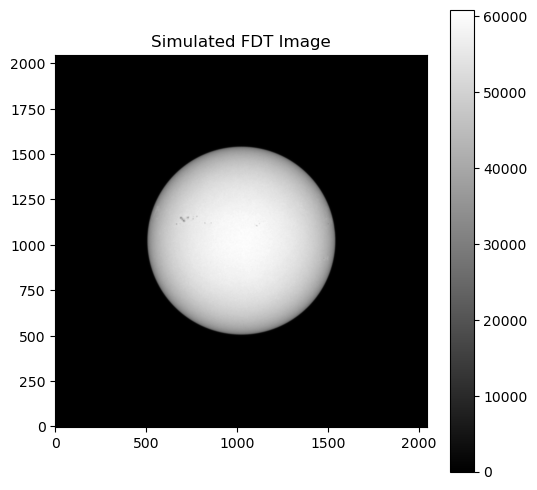

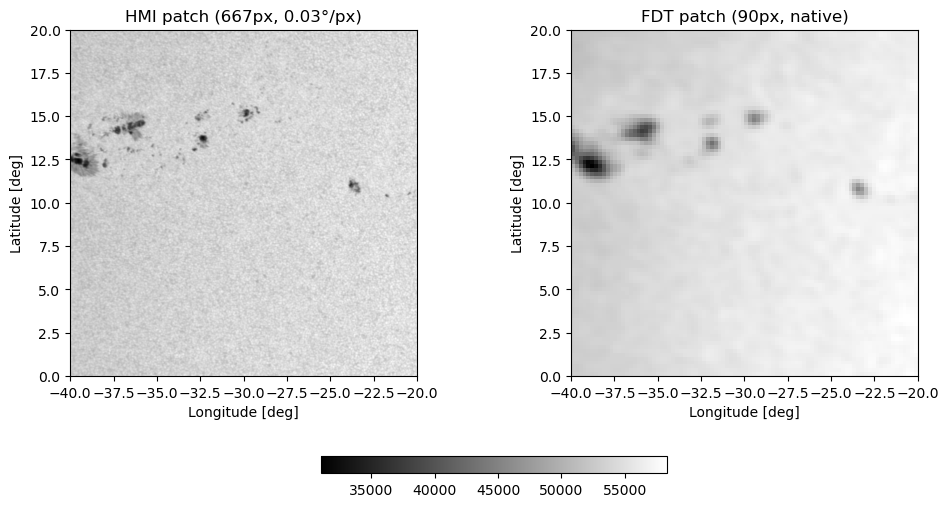

Patch sizes: HMI 667px, FDT 90px


In [57]:
# Generate WCS
hmi_image = imgs[0]
fdt_image = simulate_fdt_from_hmi(np.nan_to_num(imgs[0]), psf_rel_fdt)

# Plot the fdt image
plt.figure(figsize=(6, 6))
plt.imshow(fdt_image, cmap='gray', origin='lower')
plt.title("Simulated FDT Image")
plt.colorbar()
# Build WCS
hmi_wcs, fdt_wcs = make_wcs_from_keys_table(f, fdt_shape=(2048, 2048), pix_fdt=3.75)

# Plot patch
plot_hmi_fdt_patch_disk_fixed(hmi_image, fdt_image, hmi_wcs, fdt_wcs, f,
                                   lat_range=(0, 20), lon_range=(-40, -20),cmap='gray', fdt_distance_au=0.5)

In [6]:
# plt.figure()
# plt.imshow(psf, cmap='gray', vmin=0, vmax=1e-9, origin='lower')
# plt.colorbar()

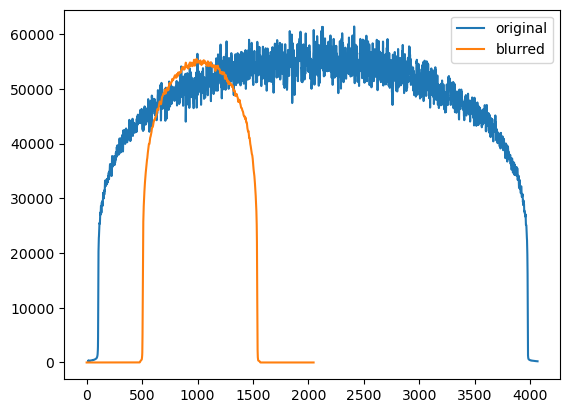

In [12]:
plt.plot(imgs[0][2048, :], label='original')
plt.plot(img1_2k[1024, :], label='blurred')
plt.legend()

Pixel coords HMI 1: y(1862,2222), x(1862,2222)
Pixel coords HMI 2: y(1862,2222), x(1862,2222)
Pixel coords FDT 1: y(1000,1048), x(1000,1048)
Pixel coords FDT 2: y(1000,1048), x(1000,1048)


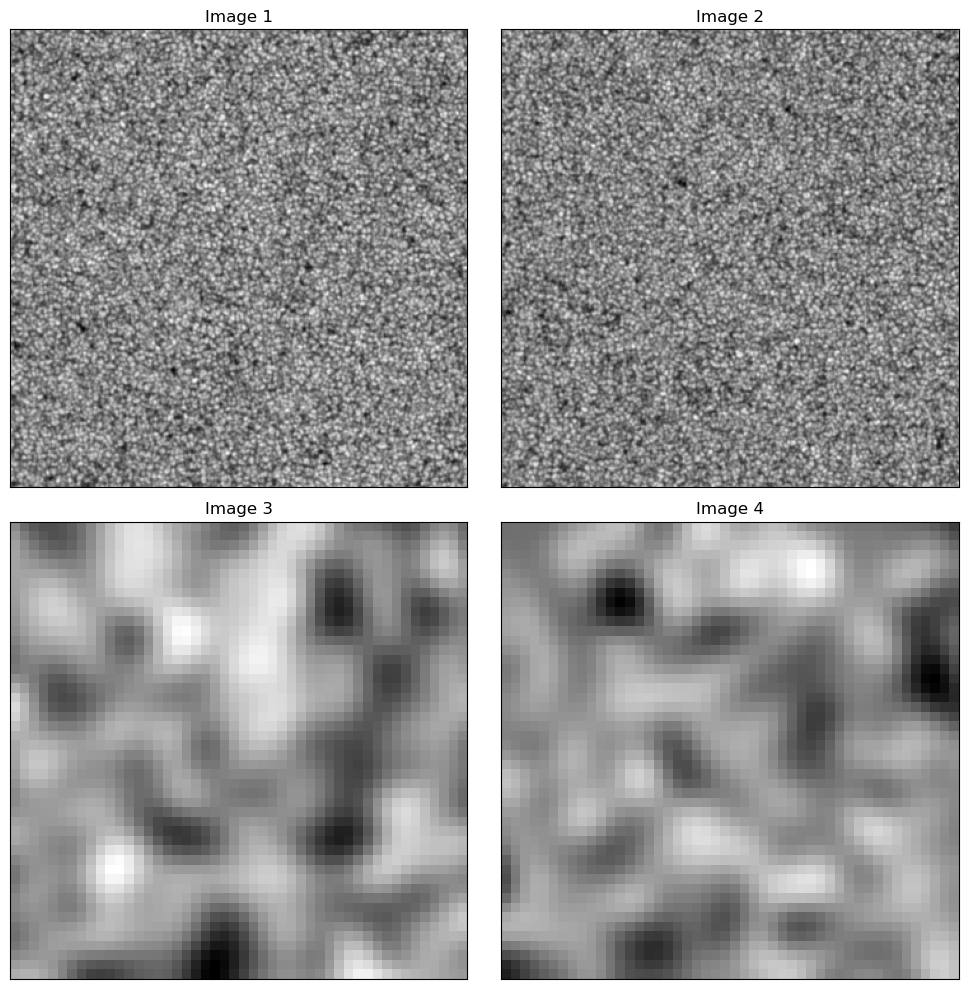

In [17]:
# Plot the same region of interest in terms of latitude and longitude
lat_min, lat_max = -90, 90
lon_min, lon_max = -90, 90
# Convert to pixel coordinates
def latlon_to_pixel(lat, lon, crpix, solar_radius_arcsec, pixel_scale):
    """Convert latitude and longitude in arcseconds to pixel coordinates."""
    x = crpix + lon / pixel_scale
    y = crpix + lat / pixel_scale
    return int(y), int(x)
y1_min, x1_min = latlon_to_pixel(lat_min, lon_min, crpixs[0], solar_radius_arcsec_hmi, pix_hmi)
y1_max, x1_max = latlon_to_pixel(lat_max, lon_max, crpixs[0], solar_radius_arcsec_hmi, pix_hmi)
y2_min, x2_min = latlon_to_pixel(lat_min, lon_min, crpixs[1], solar_radius_arcsec_hmi, pix_hmi)
y2_max, x2_max = latlon_to_pixel(lat_max, lon_max, crpixs[1], solar_radius_arcsec_hmi, pix_hmi)
y1_min_fdt, x1_min_fdt = latlon_to_pixel(lat_min, lon_min, 1024, solar_radius_arcsec_fdt, pix_fdt)
y1_max_fdt, x1_max_fdt = latlon_to_pixel(lat_max, lon_max, 1024, solar_radius_arcsec_fdt, pix_fdt)
y2_min_fdt, x2_min_fdt = latlon_to_pixel(lat_min, lon_min, 1024, solar_radius_arcsec_fdt, pix_fdt)
y2_max_fdt, x2_max_fdt = latlon_to_pixel(lat_max, lon_max, 1024, solar_radius_arcsec_fdt, pix_fdt)
print(f'Pixel coords HMI 1: y({y1_min},{y1_max}), x({x1_min},{x1_max})')
print(f'Pixel coords HMI 2: y({y2_min},{y2_max}), x({x2_min},{x2_max})')
print(f'Pixel coords FDT 1: y({y1_min_fdt},{y1_max_fdt}), x({x1_min_fdt},{x1_max_fdt})')
print(f'Pixel coords FDT 2: y({y2_min_fdt},{y2_max_fdt}), x({x2_min_fdt},{x2_max_fdt})')
figs, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(imgs[0][y1_min:y1_max, x1_min:x1_max], cmap='gray', origin='lower')
ax[0, 1].imshow(imgs[1][y2_min:y2_max, x2_min:x2_max], cmap='gray', origin='lower')
ax[1, 0].imshow(img1_2k[y1_min_fdt:y1_max_fdt, x1_min_fdt:x1_max_fdt], cmap='gray', origin='lower')
ax[1, 1].imshow(img2_2k[y2_min_fdt:y2_max_fdt, x2_min_fdt:x2_max_fdt], cmap='gray', origin='lower')
for i in range(2):
    for j in range(2):
        ax[i, j].set_title(f'Image {i*2+j+1}')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.tight_layout()
plt.show()


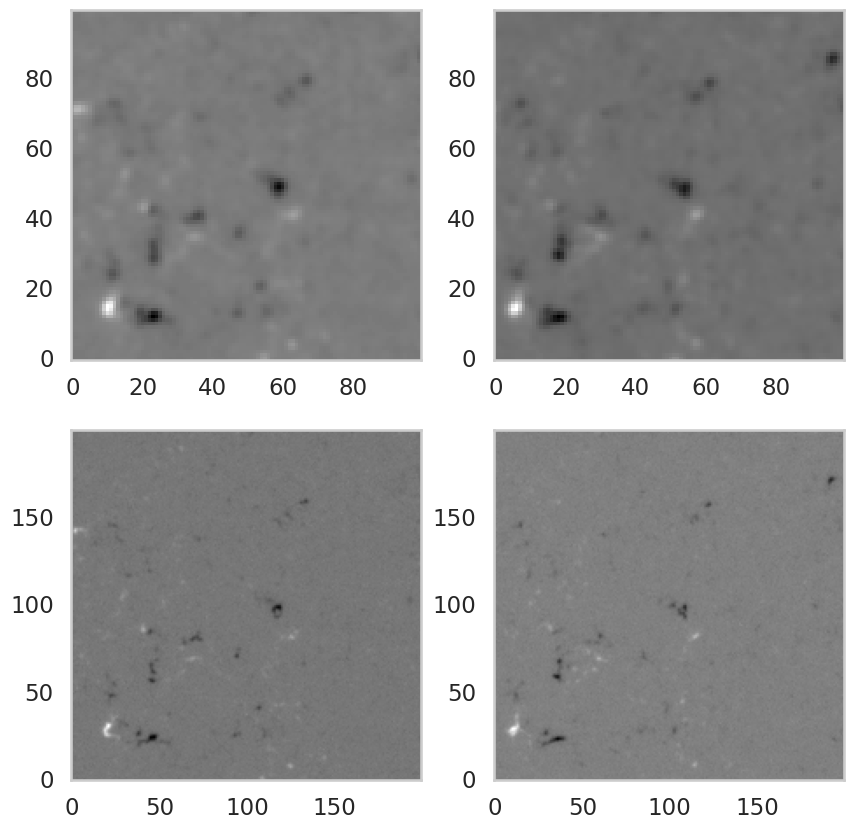

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(img1_2k[1024-50:1024+50, 1024-50:1024+50], cmap='gray', origin='lower')
ax[0, 1].imshow(img2_2k[1024-50:1024+50, 1024-50:1024+50], cmap='gray', origin='lower')
ax[1, 0].imshow(imgs[0][2048-100:2048+100, 2048-100:2048+100], cmap='gray', origin='lower')
ax[1, 1].imshow(imgs[1][2048-100:2048+100, 2048-100:2048+100], cmap='gray', origin='lower')

# Turn off grid for all panels
for i in range(2):
    for j in range(2):
        ax[i, j].grid(False)

plt.show()


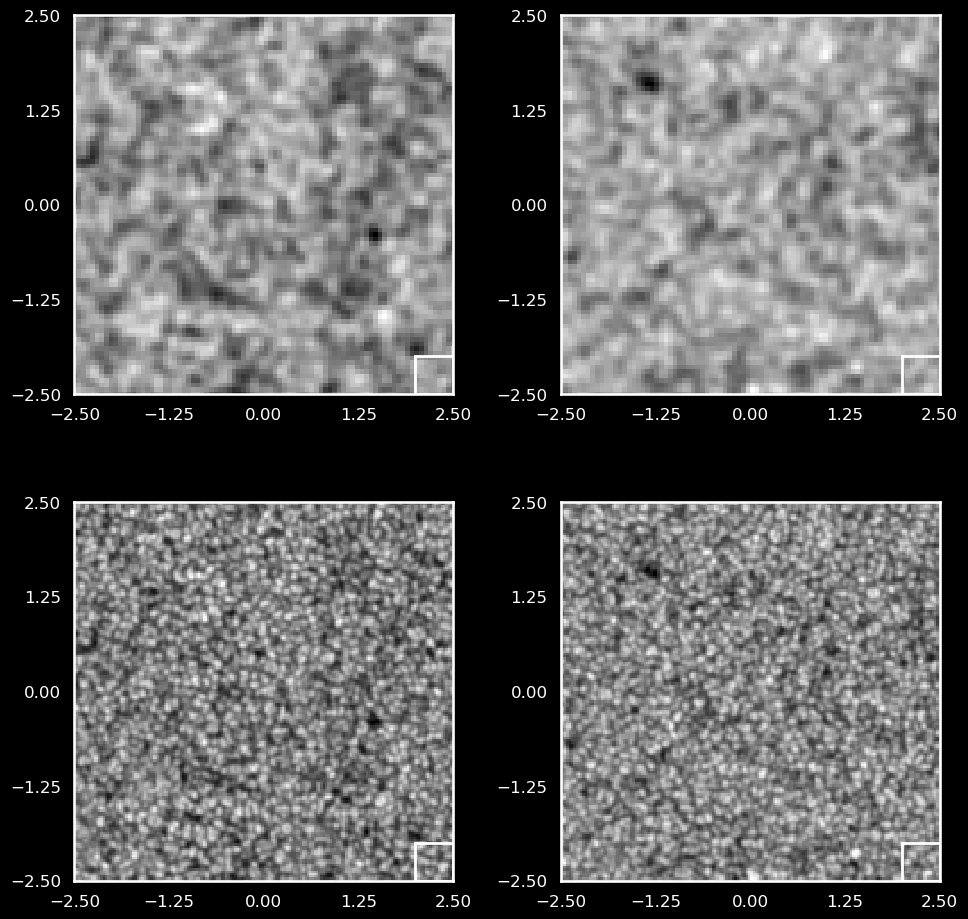

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Apply seaborn style
sns.set_context('talk')
sns.set_style('white')

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Define physical extent
extent = (-2.5, 2.5)
n_pixels_top = 84
n_pixels_bottom = 168

# Generate coordinate grids
x_top = np.linspace(extent[0], extent[1], n_pixels_top)
y_top = np.linspace(extent[0], extent[1], n_pixels_top)
x_bottom = np.linspace(extent[0], extent[1], n_pixels_bottom)
y_bottom = np.linspace(extent[0], extent[1], n_pixels_bottom)

X_top, Y_top = np.meshgrid(x_top, y_top)
X_bottom, Y_bottom = np.meshgrid(x_bottom, y_bottom)

# Plot with pcolormesh
ax[0, 0].pcolormesh(X_top, Y_top, img1_2k[1024-42:1024+42, 1024-42:1024+42], cmap='gray', shading='auto')
ax[0, 1].pcolormesh(X_top, Y_top, img2_2k[1024-42:1024+42, 1024-42:1024+42], cmap='gray', shading='auto')
ax[1, 0].pcolormesh(X_bottom, Y_bottom, imgs[0][2048-84:2048+84, 2048-84:2048+84], cmap='gray', shading='auto')
ax[1, 1].pcolormesh(X_bottom, Y_bottom, imgs[1][2048-84:2048+84, 2048-84:2048+84], cmap='gray', shading='auto')

# Draw white box in bottom-right
box_size = 0.5
for i in range(2):
    ax[0, i].add_patch(Rectangle(
        (2.5 - box_size, -2.5),
        box_size,
        box_size,
        edgecolor='white',
        facecolor='none',
        linewidth=2
    ))
    ax[1, i].add_patch(Rectangle(
        (2.5 - box_size, -2.5),
        box_size,
        box_size,
        edgecolor='white',
        facecolor='none',
        linewidth=2
    ))

# Format axes: show ticks, set color, style
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(extent)
        ax[i, j].set_ylim(extent)
        ax[i, j].set_aspect('equal')
        ax[i, j].grid(False)

        # Enable ticks
        ax[i, j].tick_params(
            direction='out',
            length=6,
            width=1.5,
            colors='white',  # Make ticks white to show up on grayscale
            labelcolor='white'
        )

        # Set tick labels
        ax[i, j].set_xticks(np.linspace(-2.5, 2.5, 5))
        ax[i, j].set_yticks(np.linspace(-2.5, 2.5, 5))

        # Set tick label font size
        ax[i, j].tick_params(labelsize=12)

        # Optional: set spine color if needed
        for spine in ax[i, j].spines.values():
            spine.set_edgecolor('white')

# Dark background to improve contrast
fig.patch.set_facecolor('black')
for a in ax.ravel():
    a.set_facecolor('black')

plt.tight_layout()
plt.show()


In [14]:
patch_2k_10deg_gran = img1_2k[1024-84:1024+84, 1024-84:1024+84]
patch_4k_10deg_gran = imgs[0][2048-168:2048+168, 2048-168:2048+168]

# plt.imshow(patch_4k_5deg_gran, cmap='gray')
# plt.show()

np.save('patch_2k_10deg_gran.npy', patch_2k_10deg_gran)
np.save('patch_4k_10deg_gran.npy', patch_4k_10deg_gran)

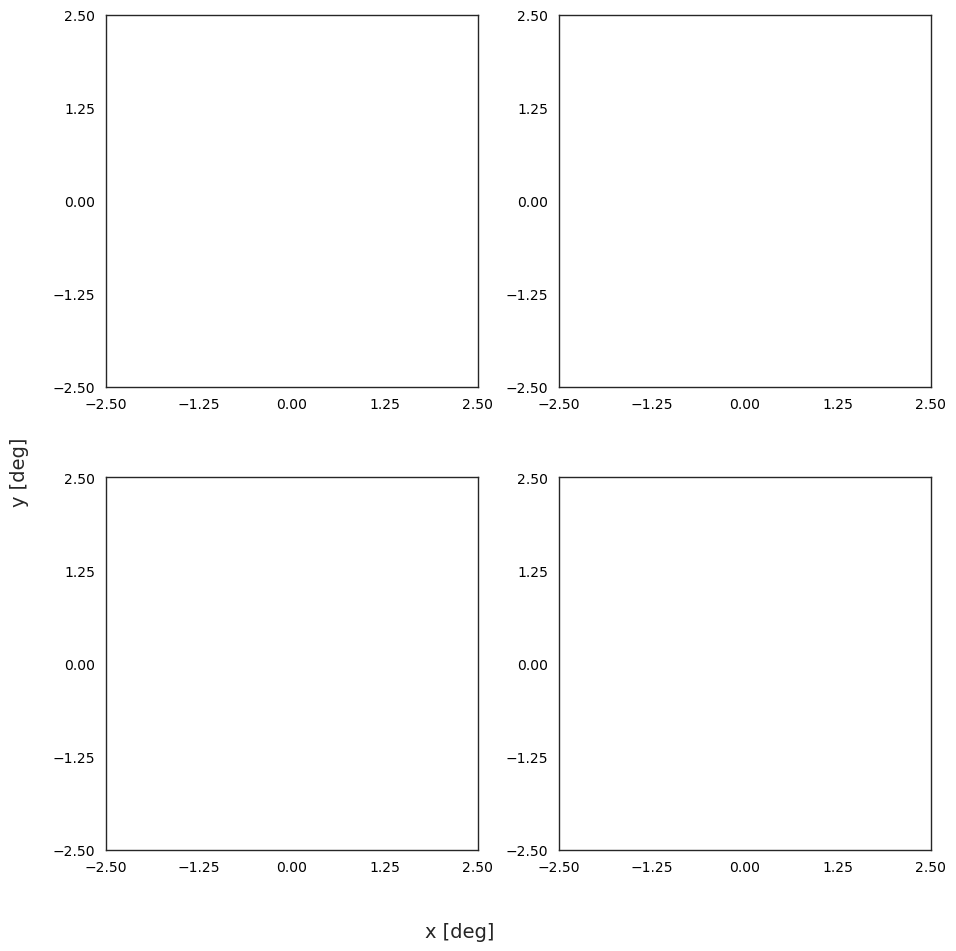

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Rectangle

# Use seaborn for clean plot style
sns.set_context('paper')  # smaller text suitable for paper
sns.set_style('white')    # clean white background

fig, ax = plt.subplots(2, 2, figsize=(10, 10))

# Define physical extent in all axes
extent = (-2.5, 2.5)

# Image sizes
n_pixels_top = 84 # 168
n_pixels_bottom = 168 # 336

# Coordinate grids
x_top = np.linspace(extent[0], extent[1], n_pixels_top)
y_top = np.linspace(extent[0], extent[1], n_pixels_top)
x_bottom = np.linspace(extent[0], extent[1], n_pixels_bottom)
y_bottom = np.linspace(extent[0], extent[1], n_pixels_bottom)
X_top, Y_top = np.meshgrid(x_top, y_top)
X_bottom, Y_bottom = np.meshgrid(x_bottom, y_bottom)

# Plot grayscale data with consistent extent
ax[0, 0].pcolormesh(X_top, Y_top, img1_2k[1024-42:1024+42, 1024-42:1024+42], cmap='gray', shading='auto', rasterized = True, vmax = 100, vmin = -100)
ax[0, 1].pcolormesh(X_top, Y_top, img2_2k[1024-42:1024+42, 1024-42:1024+42], cmap='gray', shading='auto', rasterized = True, vmax = 100, vmin = -100)
ax[1, 0].pcolormesh(X_bottom, Y_bottom, imgs[0][2048-84:2048+84, 2048-84:2048+84], cmap='gray', shading='auto', rasterized = True, vmax = 100, vmin = -100)
ax[1, 1].pcolormesh(X_bottom, Y_bottom, imgs[1][2048-84:2048+84, 2048-84:2048+84], cmap='gray', shading='auto', rasterized = True, vmax = 100, vmin = -100)

# White box size in physical units
box_size = 1

# Bottom-right corner box placement
for i in range(2):
    ax[0, i].add_patch(Rectangle(
        (1.0 - box_size, -0.25),  # bottom-right corner
        box_size, box_size,
        edgecolor='white',
        facecolor='none',
        linewidth=2
    ))
    ax[1, i].add_patch(Rectangle(
        (1.0 - box_size, -0.25),  # bottom-right corner
        box_size, box_size,
        edgecolor='white',
        facecolor='none',
        linewidth=2
    ))

# Format all axes
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(extent)
        ax[i, j].set_ylim(extent)
        ax[i, j].set_aspect('equal')

        # Clean ticks and labels
        ax[i, j].tick_params(
            direction='out',
            length=4,
            width=1,
            colors='black',
            labelcolor='black',
            labelsize=10
        )
        ax[i, j].set_xticks(np.linspace(-2.5, 2.5, 5))
        ax[i, j].set_yticks(np.linspace(-2.5, 2.5, 5))

# Remove grid and ensure clean white layout
# Common axis labels
fig.text(0.5, 0.04, 'x [deg]', ha='center', va='center', fontsize=14)
fig.text(0.06, 0.5, 'y [deg]', ha='center', va='center', rotation='vertical', fontsize=14)

# Individual tick settings (optional, already included before)
for i in range(2):
    for j in range(2):
        ax[i, j].set_xlim(extent)
        ax[i, j].set_ylim(extent)
        ax[i, j].tick_params(
            direction='out',
            length=4,
            width=1,
            colors='black',
            labelcolor='black',
            labelsize=10
        )
        ax[i, j].set_xticks(np.linspace(-2.5, 2.5, 5))
        ax[i, j].set_yticks(np.linspace(-2.5, 2.5, 5))

plt.tight_layout(rect=[0.08, 0.06, 1, 1])
# plt.tight_layout()
# plt.savefig('pmi_hmi_comparison_mag.pdf',bbox_inches='tight')
plt.show()
